%matplotlib-  IPython 에서 제공하는 Rich output(그림, 소리, 애니메이션) 에 대한 표현 방식  
https://korbillgates.tistory.com/85

inline 브라우저(실행코드 창 1줄) 내부에서 바로 Rich output출력  
https://korbillgates.tistory.com/85

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


### 학습시작

In [ ]:
import torch
import torch.nn as nn                     
import torch.nn.functional as F           # 손실함수

import torch.optim as optim               # optimizer
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

> .manual_seed : random seed(난수 발생)를 고정하기 위한 함수, 동일한 셋트의 난수를 생성할 수 있게 하는 것이다.  
https://rabo0313.tistory.com/entry/pytorch-torchmanualseed
> * torch.manual_seed : cpu 연산 무작위 고정  
> * torch.manual_seed_all: 멀티 gpu 연산 고정
 https://www.facebook.com/groups/PyTorchKR/posts/927731617366520/?mibextid=HsNCOg  

---

→ torch.manual_seed(777)와 torch.cuda.manual_seed_all(777)을 쓰는 이유  
: 학습을 위한 실험을 할 때 무작위성을 컨트롤하기 위해 사용. 시드가 무작위로 변하면 학습 모델의 결과를 확인할 때 무엇이 문제인지 파악하기 어려워짐. reproducible(재현성)한 실험을 하기 위해 시드를 고정해둘 필요가 있다. Pytorch에서 무작위성을 배제하고 일관된 학습 결과를 얻으려면 다음과 같은 코드를 사용하면 된다.  
https://moding.tistory.com/entry/Pytorch%EB%A1%9C-Fashion-MNIST-%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0  
+재현성 : AI 모델을 재현할 수 있는 정도
참고 자료  
→ https://www.ciokorea.com/news/39720   
→ https://www.dailysecu.com/news/articleView.html?idxno=24286


---


+인공지능 학습을 진행할 때 다양한 랜덤요소들이 있음(데이터를 넣을 시작점 등)이를 제어함. (n)안의 숫자는 n번째 랜덤한 숫자 사용을 의미함. 실제 서비스할 때는 의미 없는 기능이지만 이 모델을 재현할 때, 실험 당시 정확도가 가장 높았던 실험 조건을 위해서? 사용.

### 데이터

데이터 세트 불러오기

In [ ]:
# 정규화 설정
transform = transforms.Compose( # 여러단계로 변환 시 묶어서 사용할 수 있게 함.
    [transforms.ToTensor(), # 데이터를 Tensor로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # (mean, std, inplace=False) / 
                                                              # (R채널 평균, G ", B "), (R채널 표준편차, G ", B ") 
                                                              # 각 채널별 평균(mean)을 뺀 뒤 표준편차(std)로 나누어 정규화.

batch_size = 13

# 데이터세트 불러오기
trainset = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/ETC/2022/Competition_DentalAI/apple_dataset/train',
                                             transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root = '/content/drive/MyDrive/ETC/2022/Competition_DentalAI/apple_dataset/test',
                                             transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

> .Normalize 해주는 이유 : 숫자가 커지는 것을 막기 위해서  
: 인공지능 학습은 곱셈과 나눗셈의 연속임. 때문에 숫자가 한없이 커지거나 작아질 수 있음. 그렇게 되면 학습 속도가 떨어짐. 때문에 이를 방지하고자 0~1 사이의 숫자로 이미지의 RGB값을 변환해서 학습을 위한 데이터 처리를 거치는 것. 그래서 사용할 때 이 코드와 같이 0.5를 기준으로 맞추던가 아니면 걍 255로 나누기도 함.

> ImageFolder : 폴더명을 레이블(label)로 만들어줌

* 학습 데이터 섞는 이유 : 샘플링 편향을 막기 위해서  
: 학습 할 때 데이터를 넣는 순서를 모델이 학습 할 수 있기에 이를 방지.   
: 테스트는 안 섞는 이유 : 학습을 하지 않아서 모델의 정확도에 영향을 미치지 않음

> DataLoader : batchsize - 모델 학습 시킬 때 에폭 한번 당 모델에 데이터 개수(이거 정의 다시 한번 정리)


In [ ]:
# classes가 각 폴더를 배열 형태로 담음
len(classes)

13

#### 데이터 세트 분석

---
1. 샘플
2. 크기
3. 개수
4. 비율
5. 분포


https://www.sas.com/ko_kr/solutions/ai-mic/blog/machine-learning-data-set.html

##### 샘플

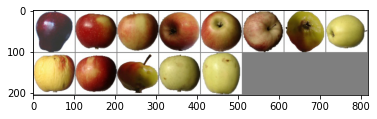

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    # .transpose : pytorch에서 [Batch Size, Channel, Width, Height] 순으로 저장 된것을 
    # 다시 [Width, Height, Channel]형태로 변경해줌
    plt.show()


# 학습용 이미지를 무작위로 가져오기 : suffle로 가져왔기 때문에 무작위.
dataiter = iter(trainloader)  # :iter타입으로 변경
images, labels = dataiter.next()  #iter 타입의 객체에서 갑을 하나씩 뽑아옴

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' / '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

iterator 객체안의 있는 두 함수:반복가능(iterable)한 객체에 적용  
https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=youndok&logNo=222073036603  
iter(), next():수동적 for문  
https://seong6496.tistory.com/81


##### 개수

https://ndb796.tistory.com/658

##### 분포 


https://velog.io/@katinon/%ED%98%BC%EA%B3%B5%EB%A8%B8%EC%8B%A0-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%97%90%EC%84%9C%EC%9D%98-%EC%A7%80%EB%8F%84%ED%95%99%EC%8A%B5%EA%B3%BC-%EC%83%98%ED%94%8C%EB%A7%81-%ED%8E%B8%ED%96%A5

#### 데이터세트 분리

https://mgyo.tistory.com/75

### 모델

In [ ]:
# mobilenetV3 불러오기
import torchvision.models as models
from torchsummary import summary    # 모델 개요 확인 함수

model = models.mobilenet_v3_small(num_classes=13).to(device)

In [ ]:
# 모델 정보 출력. 11개의 층으로 이루어짐.
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()   # 손실 함수
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # optimizer SGD(경사하강법)사용

###### 손실함수 - 교차 엔드로피 오차(CrossEntropyLoss)

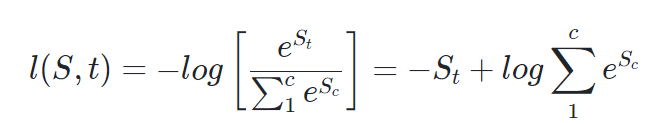

l : loss function을 의미함  
S : network model이 마지막으로 뱉는 output을 의미, **자 nn.CrossEntropyLoss에는 이미 nn.LogSoftmax가 포함되어 있다. 따라서 log값이 씌워진 output값이 아닌 생 output값을 줘야함 즉, raw data! = logits, score**  
t : target, multi-class binary로 정답인 Class의 넘버라고 생각하면 된다.  
St : 정답인 Class의 예측 score 값  
c : Class의 개수, 여기서는 10!  
https://velog.io/@olxtar/nn.CrossEntropyLoss

##### 최적화 기법 - SGD

Stochastic Gradient Descent : 전체 data를 가지고 한번의 loss function을 계산하는게 아니라 batch단위로 loss function을 계산.  
https://powerofsummary.tistory.com/117

##### 오류코드 1, 2 : 해결됨

In [ ]:
#오류 코드 1 _ 20221121 : 해결됨

for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: ignored

In [ ]:
#오류 코드 2 _ 20221122 : 해결됨
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs.cuda())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        inputs = inputs.cpu()
        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: ignored

##### 모델 학습

In [ ]:

for epoch in range(2):   # 데이터셋을 수차례 반복합니다. epoch : 2 / batch_size : 13 (class  개수대로)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs.cuda())
        loss = criterion(outputs.cpu(), labels) # criterion : 손실함수
        loss.backward() # 자동 미분
        optimizer.step()
        # inputs = inputs.cpu()
        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}') # loss : loss 평균값 출력
                                                                      # .3f:소수점 3자리만 출력
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 1.950
[1,   200] loss: 1.861
[1,   300] loss: 1.631
[1,   400] loss: 1.458
[2,   100] loss: 1.142
[2,   200] loss: 0.982
[2,   300] loss: 0.812
[2,   400] loss: 0.657
Finished Training


.backward() 역전파 알고리즘에서 많이 사용. 기울기 계산함  
https://velog.io/@jkl133/pytorch%EC%9D%98-autograd%EC%97%90-%EB%8C%80%ED%95%B4-%EC%95%8C%EC%95%84%EB%B3%B4%EC%9E%90


optimizer.step() : 계산된 gradient가 실제 weight에 update 함.  
https://gaussian37.github.io/dl-pytorch-snippets/#optimizerstep%EC%9D%84-%ED%86%B5%ED%95%9C-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-%EC%97%85%EB%8D%B0%EC%9D%B4%ED%8A%B8%EC%99%80-lossbackward%EC%99%80%EC%9D%98-%EA%B4%80%EA%B3%84-1

##### 학습 현황 확인

https://gaussian37.github.io/dl-pytorch-observe/

##### 오류 코드 3, 4 : 해결됨

In [ ]:
# 오류 코드 3 : 해결됨 : 배치 사이즈가 4여서 아예 없는 클래스 부르려니까 오류 났음
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(1)))

NameError: ignored

#### 전체 데이터셋에 대해 어떻게 작동하는가

#### 혼돈 행렬

##### 모델 평가 지표

https://rabo0313.tistory.com/entry/ML-%EB%B6%84%EB%A5%98-%EB%AA%A8%EB%8D%B8-%EC%84%B1%EB%8A%A5-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C-Confusion-Matrix-accuracy-precision-recall-f1-score-ROC-AUC-curve

https://skillmemory.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EB%B6%84%EB%A5%98-%ED%98%BC%EB%8F%99-%ED%96%89%EB%A0%ACConfusion-matrix

https://truman.tistory.com/179

##### .

In [ ]:
outputs = model(images.cuda())

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(13)))

Predicted:  Apple Pink Lady Apple Red Yellow 2 Apple Pink Lady Apple Golden 1


##### 오류코드 4 : 해결됨

In [ ]:
# 오류 코드 4 : 해결됨
# cpu, gpu 혼선

correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = model(images.cuda())
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

RuntimeError: ignored

In [ ]:
# 오류 코드 4

correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = model(images.cuda())
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


#### 각 분류별 정확도 출력

In [ ]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        outputs = model(images.cuda())
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Apple Braeburn is 14.0 %
Accuracy for class: Apple Crimson Snow is 8.1 %
Accuracy for class: Apple Golden 1 is 8.1 %
Accuracy for class: Apple Golden 2 is 9.1 %
Accuracy for class: Apple Golden 3 is 3.7 %
Accuracy for class: Apple Granny Smith is 7.3 %
Accuracy for class: Apple Pink Lady is 7.2 %
Accuracy for class: Apple Red 1 is 9.8 %
Accuracy for class: Apple Red 2 is 7.3 %
Accuracy for class: Apple Red 3 is 13.9 %
Accuracy for class: Apple Red Delicious is 13.9 %
Accuracy for class: Apple Red Yellow 1 is 13.4 %
Accuracy for class: Apple Red Yellow 2 is 14.2 %
